# library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras

# keras: for data processing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# keras: for Deep-learing
from keras.layers import *
from keras.models import *
from keras.activations import *
from keras.callbacks import EarlyStopping

/home/taeyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/taeyong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# data processing

In [2]:
# data load
data = pd.read_csv('./data/uci_news_aggregator.csv', delimiter = ',', skiprows = 1,
                   names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY',
                            'HOSTNAME', 'TIMESTAMP'], usecols=['TITLE', 'CATEGORY'])

In [3]:
data.head(5)

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [4]:
np.array(data).shape

(422419, 2)

In [5]:
# # remove punctuation and lowercase
# def normalize_text(s):
#     s = s.lower()
    
#     # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
#     s = re.sub('\s\W',' ',s)
#     s = re.sub('\W\s',' ',s)
    
#     # make sure we didn't introduce any double spaces
#     s = re.sub('\s+',' ',s)
    
#     return s

In [6]:
# news['TEXT'] = [normalize_text(s) for s in news['TITLE']]

# construct label

In [7]:
#  [1. 0. 0. 0.] e
#  [0. 1. 0. 0.] b
#  [0. 0. 1. 0.] t
#  [0. 0. 0. 1.] m

In [8]:
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [9]:
# data slicing
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))

e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]

concated = pd.concat([e,b,t,m], ignore_index=True)

In [10]:
np.array(concated).shape

(180000, 2)

In [11]:
# label col
concated['LABEL'] = 0

In [12]:
concated.head(5)

,TITLE,CATEGORY,LABEL
0,Witches of East End Star Jenna Dewan-Tatum Pos...,e,0
1,GI Joe creator Donald Levine dies aged 86,e,0
2,Why I'm Giving It All to the National Septembe...,e,0
3,Kanye West slams Annie Leibovitz over Kim Kard...,e,0
4,Kim Kardashian speaks out about racism in new ...,e,0


In [13]:
np.array(concated).shape

(180000, 3)

In [14]:
concated = concated.reindex(np.random.permutation(concated.index))

concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3

In [15]:
concated['LABEL'][:10]

78672     1
121369    2
168084    3
159435    3
53111     1
24363     0
99012     2
93816     2
165199    3
134295    2
Name: LABEL, dtype: int64

In [16]:
# one-hot encoding
labels = to_categorical(concated['LABEL'], num_classes=4)

In [17]:
labels[:10]

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

# construct train & test dataset

In [18]:
n_most_common_words = 8000
max_len = 130

In [19]:
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [20]:
concated['TITLE'].values

array(['US navy forces hand over seized oil tanker to Libya',
       "Hot cars debuting at this year's New York auto show",
       'Discovery Center Museum to host NanoDay celebration', ...,
       'Amazon Appstore Grows to Over 240000 Programs and Games',
       'Neil deGrasse Tyson Sermon',
       "Lea Michele Drives Late Cory Monteith's Range Rover"],
      dtype=object)

In [21]:
tokenizer.fit_on_texts(concated['TITLE'].values)

In [22]:
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)

In [23]:
sequences[:10]

[[13, 3771, 2206, 3167, 25, 7989, 173, 3822, 1, 2593],
 [1044, 264, 11, 57, 3486, 10, 301, 651, 111],
 [2031, 1230, 1238, 1, 1066, 4013],
 [52, 555, 3823, 4056, 313, 18, 33],
 [6059, 7, 5152, 444, 3572, 6, 514],
 [6310, 2321, 3, 1485, 139, 1, 2429, 4, 3, 2619, 3573],
 [2558, 5, 59, 5404, 988, 221, 9, 8, 171],
 [833, 6, 537],
 [3069, 725, 8, 598, 76, 5330],
 [7376, 7583, 181, 146, 1, 198, 25, 781]]

In [24]:
word_index = tokenizer.word_index

In [25]:
word_index

{'to': 1,
 'in': 2,
 'the': 3,
 'of': 4,
 'for': 5,
 'on': 6,
 'and': 7,
 'a': 8,
 'with': 9,
 'new': 10,
 'at': 11,
 'is': 12,
 'us': 13,
 'as': 14,
 'from': 15,
 'after': 16,
 'up': 17,
 'be': 18,
 'by': 19,
 'google': 20,
 'says': 21,
 'may': 22,
 'more': 23,
 'study': 24,
 'over': 25,
 'apple': 26,
 'ebola': 27,
 'will': 28,
 '1': 29,
 '2014': 30,
 'first': 31,
 '2': 32,
 'video': 33,
 'health': 34,
 'samsung': 35,
 'you': 36,
 'not': 37,
 'report': 38,
 '3': 39,
 'one': 40,
 'are': 41,
 'cancer': 42,
 'about': 43,
 '4': 44,
 'your': 45,
 'it': 46,
 'microsoft': 47,
 'could': 48,
 'galaxy': 49,
 'out': 50,
 'day': 51,
 '5': 52,
 'facebook': 53,
 'million': 54,
 'who': 55,
 'can': 56,
 'this': 57,
 'has': 58,
 'watch': 59,
 's': 60,
 'update': 61,
 'west': 62,
 'year': 63,
 'than': 64,
 'have': 65,
 'but': 66,
 'virus': 67,
 'risk': 68,
 'that': 69,
 'its': 70,
 'mers': 71,
 'how': 72,
 'deal': 73,
 'sales': 74,
 'stocks': 75,
 'china': 76,
 'off': 77,
 'what': 78,
 'news': 79,
 'no

In [26]:
X = pad_sequences(sequences, maxlen=max_len)

In [27]:
print(X.shape)
print(labels.shape)

(180000, 130)
(180000, 4)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.2, random_state=42)

In [29]:
# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)
# y_train = np.expand_dims(X_train, -1)
# y_test = np.expand_dims(X_test, -1)

In [30]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((144000, 130), (144000, 4), (36000, 130), (36000, 4))


# model

In [31]:
# model param
emb_dim = 128

In [32]:
def get_model():
    inp = Input(shape=(max_len,))
    emb = Embedding(n_most_common_words, emb_dim, input_length=max_len)(inp)
    _ = SpatialDropout1D(0.7)(emb)
    # _ = LSTM(64, dropout=0.7, recurrent_dropout=0.7)(_)
    _ = Bidirectional(LSTM(64, dropout=0.6, recurrent_dropout=0.6))(_)
    _ = Dense(64, activation="relu")(_)
    _ = Dropout(0.25)(_)
    out = Dense(4, activation='softmax')(_)
    
    return Model(inputs=inp, outputs=out)

In [33]:
model = get_model()

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 130)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total para

# train

In [35]:
# train param
epochs = 15
batch_size = 512
learning_rate = 0.001
decay = 1e-06

In [36]:
model.compile(optimizer = optimizers.adam(lr = learning_rate, decay = decay), loss='categorical_crossentropy', metrics=['acc'])

In [37]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Train on 115200 samples, validate on 28800 samples
Epoch 1/15
115200/115200 [==============================] - 108s 935us/step - loss: 0.9188 - acc: 0.5948 - val_loss: 0.3325 - val_acc: 0.8858
Epoch 2/15
115200/115200 [==============================] - 105s 911us/step - loss: 0.3906 - acc: 0.8678 - val_loss: 0.2572 - val_acc: 0.9136
Epoch 3/15
115200/115200 [==============================] - 105s 908us/step - loss: 0.3102 - acc: 0.8965 - val_loss: 0.2353 - val_acc: 0.9206
Epoch 4/15
115200/115200 [==============================] - 104s 899us/step - loss: 0.2771 - acc: 0.9076 - val_loss: 0.2230 - val_acc: 0.9236
Epoch 5/15
115200/115200 [==============================] - 103s 898us/step - loss: 0.2576 - acc: 0.9146 - val_loss: 0.2179 - val_acc: 0.9260
Epoch 6/15
115200/115200 [==============================] - 103s 898us/step - loss: 0.2389 - acc: 0.9204 - val_loss: 0.2140 - val_acc: 0.9264
Epoch 7/15
115200/115200 [==============================] - 103s 896us/step - loss: 0.2306 - acc:

In [38]:
model.save('model.h5')

# test

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

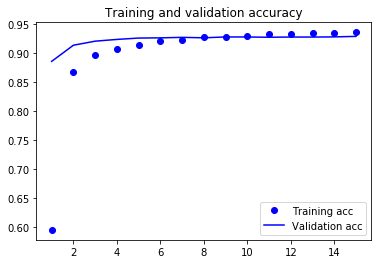

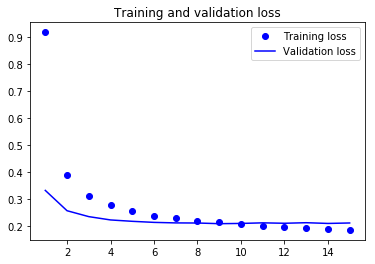

In [40]:
# visualization
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# test

labels = ['entertainment', 'bussiness', 'science/tech', 'health']
txt_list = [["Regular fast food eating linked to fertility issues in women"], ["Chinese ethnic group biggest earners in the UK"],
           ["Dozens of arrests in Copenhagen for drunk scooter driving"]]

for txt in txt_list:
    print(txt)
    sequence = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(sequence, maxlen=max_len)
    pred = model.predict(padded)
    print(pred, labels[np.argmax(pred)])

['Regular fast food eating linked to fertility issues in women']
[[2.1407239e-05 2.1338825e-04 1.4051318e-05 9.9975115e-01]] health
['Chinese ethnic group biggest earners in the UK']
[[0.00191052 0.98493594 0.00717379 0.00597969]] bussiness
['Dozens of arrests in Copenhagen for drunk scooter driving']
[[0.96398866 0.00707286 0.01535682 0.01358171]] entertainment
